In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
from sklearn.svm import SVC



%load_ext autoreload
%autoreload 2

%matplotlib inline

In [51]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
# tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
tracks = 'TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [3]:
morph_rare = ['4139265.3','4139265.4','4139265.5'] #,'4139266.3'] #,'4222175.0']
# morph_familiar = ['4222153.2','4222154.1','4222153.1','4222157.3','4222174.1','4222153.3']
morph_familiar = ['4222153.1','4222153.2','4222153.3','4222174.1']

In [4]:
def sess_lar(sess,max_pos=450,cellmask = None):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


    effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
    effMorph = (effMorph+.3)/1.6

    msort = np.argsort(effMorph)

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
    S_trial_mat[np.isnan(S_trial_mat)]=0
    posmask = centers<=max_pos
    S_tm = S_trial_mat[:,posmask,:].reshape([S_trial_mat.shape[0],-1])
    S_tm_norm = S_tm/np.linalg.norm(S_tm,ord=2,axis=1)[:,np.newaxis]
   # S_sm = np.matmul(S_tm_norm,S_tm_norm.T)


    lar = np.zeros(effMorph.shape)
    sim0 = np.zeros(effMorph.shape)
    sim1 = np.zeros(effMorph.shape)
    for trial in range(effMorph.shape[0]):
        mask0 = trial_info['morphs']==0
        mask1 = trial_info['morphs']==1
        if trial_info['morphs'][trial]==0:
            mask0[trial]=False
        elif trial_info['morphs'][trial]==1:
            mask1[trial]=False
            
        centroid0, centroid1 = np.nanmean(S_tm[mask0,:],axis=0), np.nanmean(S_tm[mask1,:],axis=0)
        centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
        centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
        
        sim0[trial],sim1[trial] = np.dot(S_tm_norm[trial,:],centroid0), np.dot(S_tm_norm[trial,:],centroid1) 
#         print(sim0,sim1)
        lar[trial]= np.log(np.dot(S_tm_norm[trial,:],centroid0)/np.dot(S_tm_norm[trial,:],centroid1))
    return lar, effMorph, sim0, sim1
        

    

In [5]:
mouse = '4222174.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1992,4222174.1,04_06_2019,1,TwoTower_foraging,80,1,CA1,2019-06-04,G:\My Drive\VR_Data\TwoTower\4222174.1\04_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\04_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\04_06_2...
2024,4222174.1,06_06_2019,2,TwoTower_foraging,91,1,CA1,2019-06-06,G:\My Drive\VR_Data\TwoTower\4222174.1\06_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\06_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\06_06_2...
2046,4222174.1,08_06_2019,2,TwoTower_foraging,67,1,CA1,2019-06-08,G:\My Drive\VR_Data\TwoTower\4222174.1\08_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\08_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\08_06_2...
2073,4222174.1,11_06_2019,2,TwoTower_foraging,64,1,CA1,2019-06-11,G:\My Drive\VR_Data\TwoTower\4222174.1\11_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\11_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\11_06_2...
2095,4222174.1,13_06_2019,2,TwoTower_foraging,66,1,CA1,2019-06-13,G:\My Drive\VR_Data\TwoTower\4222174.1\13_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\13_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\13_06_2...
2108,4222174.1,14_06_2019,2,TwoTower_foraging,70,1,CA1,2019-06-14,G:\My Drive\VR_Data\TwoTower\4222174.1\14_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\14_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\14_06_2...
2122,4222174.1,15_06_2019,3,TwoTower_foraging,71,1,CA1,2019-06-15,G:\My Drive\VR_Data\TwoTower\4222174.1\15_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\15_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\15_06_2...
2132,4222174.1,17_06_2019,2,TwoTower_foraging,58,1,CA1,2019-06-17,G:\My Drive\VR_Data\TwoTower\4222174.1\17_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\17_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\17_06_2...
2151,4222174.1,18_06_2019,2,TwoTower_foraging,67,1,,2019-06-18,G:\My Drive\VR_Data\TwoTower\4222174.1\18_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\18_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\18_06_2...


In [6]:
sess = df_mouse.iloc[-1]
print(sess)

MouseName                                                4222174.1
DateFolder                                              18_06_2019
SessionNumber                                                    2
Track                                            TwoTower_foraging
RewardCount                                                     67
Imaging                                                          1
ImagingRegion                                                     
DateTime                                       2019-06-18 00:00:00
data file        G:\My Drive\VR_Data\TwoTower\4222174.1\18_06_2...
scanfile                                                      None
scanmat          G:\My Drive\2P_Data\TwoTower\4222174.1\18_06_2...
s2pfolder        G:\My Drive\2P_Data\TwoTower\4222174.1\18_06_2...
Name: 2151, dtype: object


In [7]:
lar,em,sim0,sim1 = sess_lar(sess,max_pos=450.)

num aberrant ttls 0.0
31882 (31882,) (31882, 21) 91565


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


(80,) (80,) (80,)


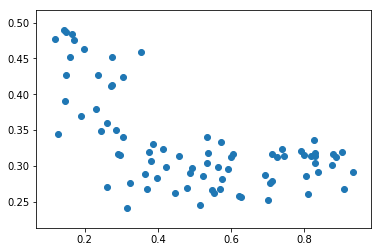

In [8]:
f,ax = plt.subplots()
print(lar.shape,sim0.shape,sim1.shape)
ax.scatter(em,sim0)

In [9]:
def LAR_list_maker(mlist,firstSess = None,max_pos=450.):
    LAR, EM,S0,S1 = {},{},{},{}
    
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for mouse,f_ind in zip(mlist,firstSess): 
        LAR[mouse],EM[mouse],S0[mouse],S1[mouse] = [],[],[],[]
        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0]).tolist()):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
#             print(sess)
            lar, em,s0,s1 = sess_lar(sess,max_pos=max_pos)
            LAR[mouse].append(lar)
            EM[mouse].append(em)
            S0[mouse].append(s0)
            S1[mouse].append(s1)
    return LAR, EM,S0,S1

In [10]:
LAR_rare,EM_rare,S0_rare,S1_rare = LAR_list_maker(morph_rare)

session ind 5
num aberrant ttls 0.0
35085 (35085,) (35085, 21) 115307
frame diff 0
session ind 6
num aberrant ttls 0.0
33140 (33140,) (33140, 21) 109003
frame diff 0
session ind 7
num aberrant ttls 0.0
38209 (38209,) (38209, 21) 126969
frame diff 0
session ind 8
num aberrant ttls 0.0
33547 (33547,) (33547, 21) 110218
frame diff 0
session ind 9
num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022
frame diff 0
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
frame diff 0
session ind 6
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
frame diff 0
session ind 7
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
frame diff 0
session ind 8
num aberrant ttls 0.0
31932 (31932,) (31932, 21) 105228
frame diff 0
session ind 9
num aberrant ttls 0.0
30493 (30493,) (30493, 21) 100982
frame diff 0
session ind 10
num aberrant ttls 0.0
32084 (32084,) (32084, 21) 105601
frame diff 0
session ind 5
num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863
frame diff 0
sess

In [11]:
LAR_fam,EM_fam,S0_fam,S1_fam = LAR_list_maker(morph_familiar,firstSess=4)

session ind 4
num aberrant ttls 0.0
36036 (36036,) (36036, 21) 118455
frame diff 0
session ind 5
num aberrant ttls 0.0
33778 (33778,) (33778, 21) 111444
frame diff 0
session ind 6
num aberrant ttls 0.0
35977 (35977,) (35977, 21) 118959
frame diff 0
session ind 4
num aberrant ttls 0.0
35248 (35248,) (35248, 21) 116195
frame diff 0
session ind 5
num aberrant ttls 0.0
33545 (33545,) (33545, 21) 121243
frame diff 0
session ind 6
num aberrant ttls 0.0
38697 (38697,) (38697, 21) 129389
frame diff 0
session ind 7
num aberrant ttls 0.0
37344 (37344,) (37344, 21) 121463
frame diff 0
session ind 4
num aberrant ttls 0.0
22769 (22769,) (22769, 21) 72892
frame diff 0
session ind 5
num aberrant ttls 0.0
13661 (13661,) (13661, 21) 44097
frame diff 0
session ind 4
num aberrant ttls 0.0
29526 (29526,) (29526, 21) 83238
frame diff 0
session ind 5
num aberrant ttls 0.0
34560 (34560,) (34560, 21) 97310
frame diff 0
session ind 6
num aberrant ttls 0.0
30879 (30879,) (30879, 21) 86531
frame diff 0
session i

In [52]:

def plot_LAR(LAR,EM,cmap='copper',ymin=-1.2,ymax=1.2):
    cmap = plt.cm.get_cmap(cmap)
    f = plt.figure()
    gs = gridspec.GridSpec(1,5)
    ax_scat = f.add_subplot(gs[:,:4])
    ax_hist = f.add_subplot(gs[:,-1])
    N = len(LAR.keys())
    bins = np.linspace(ymin,ymax)
    print(N)
    for i,mouse in enumerate(LAR.keys()):
        if len(LAR[mouse])>0:
            print(mouse)
            lar,em = np.concatenate(LAR[mouse]),np.concatenate(EM[mouse])
#             lar/=np.amax(lar)-np.amin(lar)
#             lar-=lar.mean()
#             lar/=np.amax(np.abs(lar))
            print(lar.shape)
            ax_scat.scatter(em,lar,color=cmap(np.float(i/N)),alpha=.4,s=8)
            hist,edges = np.histogram(lar,bins=bins)
            ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=cmap(np.float(i/N)),alpha=.4)
#             ax_hist.hist(lar,bins=50,orientation='horizontal',color=cmap(np.float(i/N)),alpha=.4,density=True)
    ax_hist.set_ylim([ymin,ymax])
    ax_scat.set_ylim([ymin,ymax])
    ax_hist.set_yticks([])
    return f,(ax_scat,ax_hist)

In [53]:
basedir = "G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\"

3
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(140,)
4222174.1
(400,)


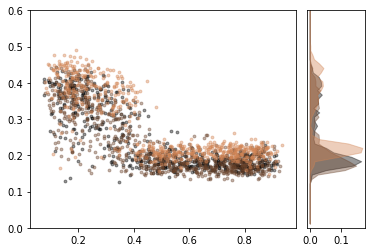

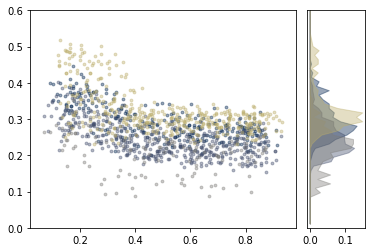

In [54]:
f,ax = plot_LAR(S0_rare,EM_rare,ymin=0,ymax=0.6)
f.savefig(os.path.join(basedir,'rare_sim0.pdf'),format='pdf')

f,ax = plot_LAR(S0_fam,EM_fam,cmap='cividis',ymin=0,ymax=.6)
f.savefig(os.path.join(basedir,'fam_sim0.pdf'),format='pdf')

3
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(140,)
4222174.1
(400,)


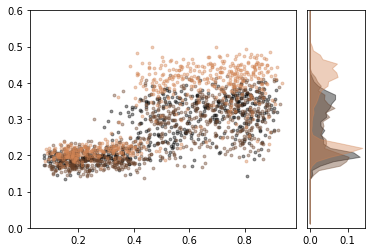

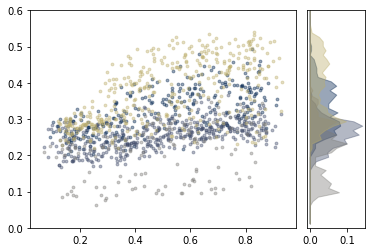

In [55]:
f,ax = plot_LAR(S1_rare,EM_rare,ymin=0,ymax=.6)
f.savefig(os.path.join(basedir,'rare_sim1.pdf'),format='pdf')
f,ax = plot_LAR(S1_fam,EM_fam,cmap='cividis',ymin=0,ymax=.6)
f.savefig(os.path.join(basedir,'fam_sim1.pdf'),format='pdf')

3
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)


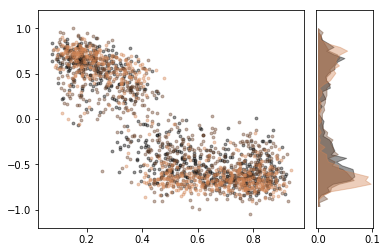

In [16]:
f,ax = plot_LAR(LAR_rare,EM_rare,cmap='copper')
f.savefig(os.path.join(basedir,'rare_simratio.pdf'),format='pdf')

4
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(140,)
4222174.1
(400,)


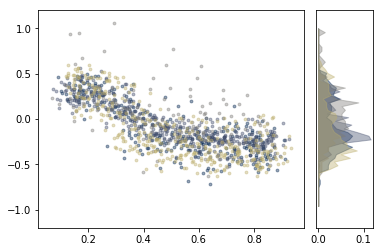

In [17]:
f,ax = plot_LAR(LAR_fam,EM_fam,cmap='cividis')
f.savefig(os.path.join(basedir,'fam_simratio.pdf'),format='pdf')

In [18]:

def mega_lar(LAR,exclude=()):
    mega_lar =  []
    for k,v in LAR.items():
        if k not in exclude:
            mega_lar.extend(v)
   
    return np.concatenate(mega_lar)


mega_lar_fam = mega_lar(LAR_fam)
mega_lar_rare = mega_lar(LAR_rare)

mega_s0_fam = mega_lar(S0_fam)
mega_s1_fam = mega_lar(S1_fam)

mega_s0_rare = mega_lar(S0_rare)
mega_s1_rare = mega_lar(S1_rare)



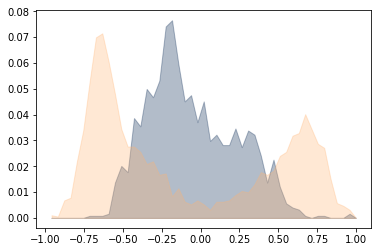

In [19]:
f,ax = plt.subplots()
bins = np.linspace(-1,1)
fam_hist,edges = np.histogram(mega_lar_fam,bins)
rare_hist,edges = np.histogram(mega_lar_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))
f.savefig(os.path.join(basedir,'lsr_hist.pdf'),format='pdf')

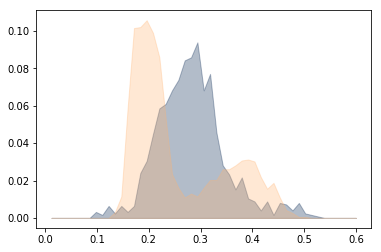

In [20]:
f,ax = plt.subplots()
bins = np.linspace(0,.6)
fam_hist,edges = np.histogram(mega_s0_fam,bins)
rare_hist,edges = np.histogram(mega_s0_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

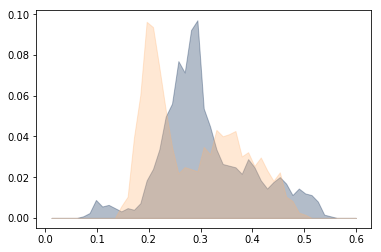

In [21]:
f,ax = plt.subplots()
bins = np.linspace(0,.6)
fam_hist,edges = np.histogram(mega_s1_fam,bins)
rare_hist,edges = np.histogram(mega_s1_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

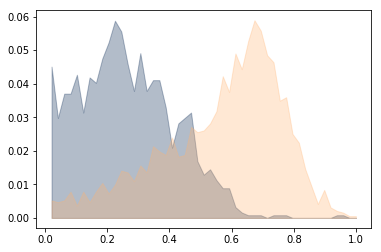

In [22]:
# plot distributions of absolute values and cdfs 
f,ax = plt.subplots()
bins = np.linspace(0,1)
fam_hist,edges = np.histogram(np.abs(mega_lar_fam),bins)
rare_hist,edges = np.histogram(np.abs(mega_lar_rare),bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

f.savefig(os.path.join(basedir,'abs_lsr_hist.pdf'),format='pdf')

(49,)


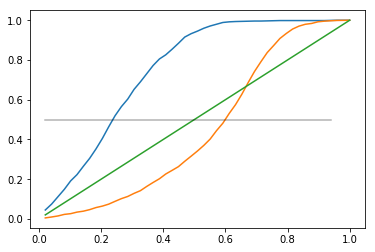

In [23]:
f,ax = plt.subplots()
print(fam_hist.shape)
fam_hist =fam_hist/fam_hist.sum()
rare_hist= rare_hist/rare_hist.sum()

ax.plot(bins[1:],np.cumsum(fam_hist))
ax.plot(bins[1:],np.cumsum(rare_hist))
ax.plot(bins[1:],bins[1:])
ax.plot(bins[1::5],.5*np.ones([10,]),alpha=.3,color='black')
f.savefig(os.path.join(basedir,'abs_lsr_cdf.pdf'),format='pdf')


In [24]:
U,p = sp.stats.mannwhitneyu(np.abs(mega_lar_rare),np.abs(mega_lar_fam))
print(U,p)

298771.0 1.202174643981953e-279


In [25]:
# compare against null hypothesis of uniform distribution, median is shifted higher than uniform distribution
uniform_null = np.random.uniform(low=0,high=np.amax(np.abs(mega_lar_rare)),size=int(1E7))
U_u,p_u = sp.stats.mannwhitneyu(np.abs(mega_lar_rare),uniform_null)
print(U_u,p_u)

9020458725.0 2.311178645724816e-06


In [26]:
r_u = 1- 2*U_u/mega_lar_rare.shape[0]/1E7
print(r_u)
print(1-U_u/mega_lar_rare.shape[0]/1E7)

0.06036888281249997
0.53018444140625


In [27]:
r = 1- 2*U/mega_lar_rare.shape[0]/mega_lar_fam.shape[0]
print(r)
print(1-U/mega_lar_rare.shape[0]/mega_lar_fam.shape[0])

0.7502248863028358
0.8751124431514179


In [28]:
basedir = "G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures"

# LAR over sessions within mouse

In [29]:
def _plot_LAR_session(lar,em,color='red',ymin=-1.2,ymax=1.2,f=None,gs=None,ax_scat = None,ax_hist=None):
    
    if f is None:
        f = plt.figure()
        gs = gridspec.GridSpec(1,5)
        ax_scat = f.add_subplot(gs[:,:4])
        ax_hist = f.add_subplot(gs[:,-1])
    
   
    bins = np.linspace(-1,1)
    ax_scat.scatter(em,lar,color=color,alpha=.6,s=8)
    hist,edges = np.histogram(lar,bins=bins)
    ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=color,alpha=.4)
#     ax_hist.hist(lar,bins=50,orientation='horizontal',color=color,alpha=.4,density=True)
    ax_hist.set_ylim([ymin,ymax])
    ax_scat.set_ylim([ymin,ymax])
    ax_hist.set_yticks([])
    return {'f':f,'ax_scat':ax_scat,'gs':gs,'ax_hist':ax_hist}

In [30]:

mouse = '4139265.4'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1371,4139265.4,07_02_2019,2,TwoTower_foraging,60,1,CA1,2019-02-07,G:\My Drive\VR_Data\TwoTower\4139265.4\07_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...
1373,4139265.4,07_02_2019,4,TwoTower_foraging,60,1,CA1,2019-02-07,G:\My Drive\VR_Data\TwoTower\4139265.4\07_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...
1407,4139265.4,10_02_2019,2,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.4\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\10_02_2...
1436,4139265.4,12_02_2019,2,TwoTower_foraging,85,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.4\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\12_02_2...
1459,4139265.4,15_02_2019,3,TwoTower_foraging,82,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.4\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\15_02_2...
1478,4139265.4,17_02_2019,2,TwoTower_foraging,94,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.4\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\17_02_2...
1489,4139265.4,18_02_2019,2,TwoTower_foraging,101,1,CA1,2019-02-18,G:\My Drive\VR_Data\TwoTower\4139265.4\18_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\18_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\18_02_2...
1498,4139265.4,19_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.4\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\19_02_2...
1510,4139265.4,20_02_2019,2,TwoTower_foraging,99,1,CA1,2019-02-20,G:\My Drive\VR_Data\TwoTower\4139265.4\20_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\20_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\20_02_2...
1516,4139265.4,21_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.4\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\21_02_2...


In [31]:
sess = df_mouse.iloc[2]
_lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)

num aberrant ttls 0.0
13506 (13506,) (13506, 21) 45655
frame diff 0


0
1
2
3
4
5


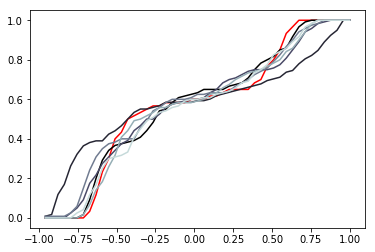

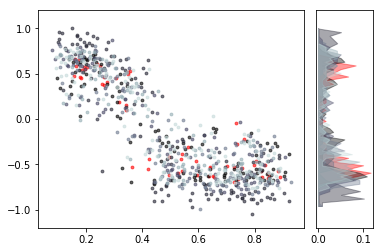

In [32]:
edges = np.linspace(-1,1)


f_cdf,ax_cdf = plt.subplots()

hist,trsh = np.histogram(_lar,edges)
hist = hist/hist.sum()
ax_cdf.plot(edges[1:],np.cumsum(hist),color='red')

fig_d = _plot_LAR_session(_lar,_em,color='red')

N = len(LAR_rare[mouse])
for sess, (lar,em) in enumerate(zip(LAR_rare[mouse],EM_rare[mouse])):
    print(sess)
    hist,trsh = np.histogram(lar,edges)
    hist=hist/hist.sum()
    ax_cdf.plot(edges[1:],np.cumsum(hist),color=plt.cm.bone(np.float(sess)/N))
    
    fig_d = _plot_LAR_session(lar,em,**fig_d,color=plt.cm.bone(np.float(sess)/N))
    
f_cdf.savefig(os.path.join(basedir,"%s_sess_lsr_cdf.pdf" % mouse),format='pdf')
fig_d['f'].savefig(os.path.join(basedir,"%s_sess_lsr.pdf" % mouse), format = 'pdf')

In [33]:
mouse = '4222153.2'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1727,4222153.2,08_04_2019,1,TwoTower_foraging,86,1,CA1,2019-04-08,G:\My Drive\VR_Data\TwoTower\4222153.2\08_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...
1751,4222153.2,10_04_2019,3,TwoTower_foraging,80,1,CA1,2019-04-10,G:\My Drive\VR_Data\TwoTower\4222153.2\10_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...
1771,4222153.2,12_04_2019,2,TwoTower_foraging,86,1,CA1,2019-04-12,G:\My Drive\VR_Data\TwoTower\4222153.2\12_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...
1788,4222153.2,14_04_2019,2,TwoTower_foraging,96,1,CA1,2019-04-14,G:\My Drive\VR_Data\TwoTower\4222153.2\14_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...
1800,4222153.2,15_04_2019,2,TwoTower_foraging,103,1,CA1,2019-04-15,G:\My Drive\VR_Data\TwoTower\4222153.2\15_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...
1816,4222153.2,16_04_2019,2,TwoTower_foraging,98,1,CA1,2019-04-16,G:\My Drive\VR_Data\TwoTower\4222153.2\16_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...
1825,4222153.2,17_04_2019,2,TwoTower_foraging,77,1,CA1,2019-04-17,G:\My Drive\VR_Data\TwoTower\4222153.2\17_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...
1833,4222153.2,18_04_2019,3,TwoTower_foraging,70,1,CA1,2019-04-18,G:\My Drive\VR_Data\TwoTower\4222153.2\18_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...


In [34]:
sess = df_mouse.iloc[1]
_lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)

num aberrant ttls 0.0
35978 (35978,) (35978, 21) 119008
frame diff 0


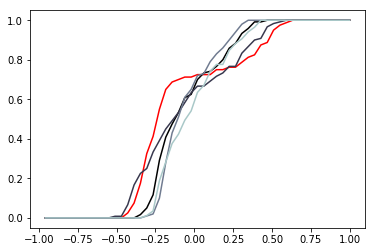

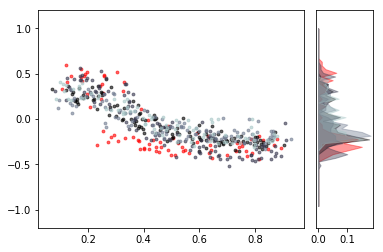

In [35]:
edges = np.linspace(-1,1)



f_cdf,ax_cdf = plt.subplots()

hist,trsh = np.histogram(_lar,edges)
hist = hist/hist.sum()
ax_cdf.plot(edges[1:],np.cumsum(hist),color='red')

fig_d = _plot_LAR_session(_lar,_em,color='red')

N = len(LAR_fam[mouse])
for sess, (lar,em) in enumerate(zip(LAR_fam[mouse],EM_fam[mouse])):
    hist,trsh = np.histogram(lar,edges)
    hist=hist/hist.sum()
    ax_cdf.plot(edges[1:],np.cumsum(hist),color=plt.cm.bone(np.float(sess)/N))
    fig_d = _plot_LAR_session(lar,em,**fig_d,color=plt.cm.bone(np.float(sess)/N))
    
    
f_cdf.savefig(os.path.join(basedir,"%s_sess_lsr_cdf.pdf" % mouse),format='pdf')
fig_d['f'].savefig(os.path.join(basedir,"%s_sess_lsr.pdf" % mouse), format = 'pdf')

num aberrant ttls 0.0
22392 (22392,) (22392, 21) 74301
frame diff 0
num aberrant ttls 0.0
13506 (13506,) (13506, 21) 45655
frame diff 0
num aberrant ttls 0.0
19948 (19948,) (19948, 21) 65960
frame diff 0


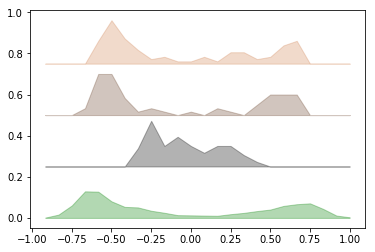

In [36]:
f,ax = plt.subplots()
bins = np.linspace(-1,1,num=25)
rare_hist,edges = np.histogram(mega_lar_rare,bins)

ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color='green')

N =3
for i,mouse in enumerate(morph_rare):
    df_mouse = df[df['MouseName'].str.match(mouse)]
    sess = df_mouse.iloc[2]
    _lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)
    _hist,edges = np.histogram(_lar,bins)
    ax.fill_between(edges[1:],_hist/_hist.sum() + (i+1)/4,y2=(i+1)/4,alpha=.3,color=plt.cm.copper(np.float(i/N)))
    
f.savefig(os.path.join(basedir,"sess3_v_latecomparison_rare.pdf"), format = 'pdf')

num aberrant ttls 0.0
one frame correction
31722 (31722,) (31722, 21) 103701
frame diff 0
num aberrant ttls 0.0
35978 (35978,) (35978, 21) 119008
frame diff 0
num aberrant ttls 0.0
24296 (24296,) (24296, 21) 79674
frame diff 0
num aberrant ttls 0.0
33583 (33583,) (33583, 21) 110386
frame diff 0


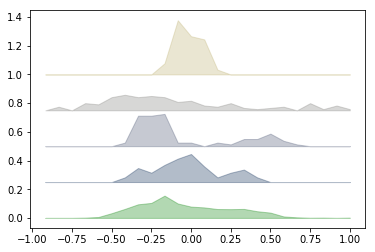

In [37]:
f,ax = plt.subplots()
bins = np.linspace(-1,1,num=25)
fam_hist,edges = np.histogram(mega_lar_fam,bins)

ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color='green')

N =4
for i,mouse in enumerate(morph_familiar):
    df_mouse = df[df['MouseName'].str.match(mouse)]
    sess = df_mouse.iloc[1]
    _lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)
    _hist,edges = np.histogram(_lar,bins)
    ax.fill_between(edges[1:],_hist/_hist.sum()+(i+1)/4,y2=(i+1)/4,alpha=.3,color=plt.cm.cividis(np.float(i/N)))

f.savefig(os.path.join(basedir,"sess3_v_latecomparison_fam.pdf"), format = 'pdf')

# comparison with familar morph with discrimination

In [42]:
LAR_fd,EM_fd,S0_fd,S1_fd = LAR_list_maker(['4222157.4'],firstSess=5)

session ind 5
num aberrant ttls 0.0
27977 (27977,) (27977, 21) 78367
frame diff 0
session ind 6
num aberrant ttls 0.0
30469 (30469,) (30469, 21) 85961
frame diff 0
session ind 7
num aberrant ttls 0.0
27484 (27484,) (27484, 21) 78628
frame diff 0
session ind 8
num aberrant ttls 0.0
24753 (24753,) (24753, 21) 71281
frame diff 0
session ind 9
num aberrant ttls 0.0
22270 (22270,) (22270, 21) 63586
frame diff 0


1
4222157.4
(500,)
1
4222157.4
(500,)


(0, 0.6)

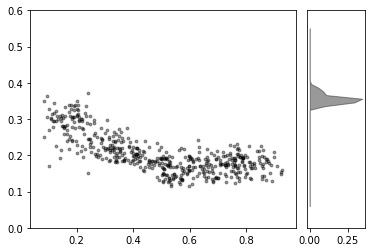

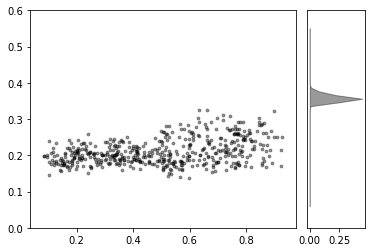

In [46]:
f,ax = plot_LAR(S0_fd,EM_fd,cmap='bone')
ax[0].set_ylim([0,.6])

f,ax = plot_LAR(S1_fd,EM_fd,cmap='bone')
ax[0].set_ylim([0,.6])

1
4222157.4
(500,)


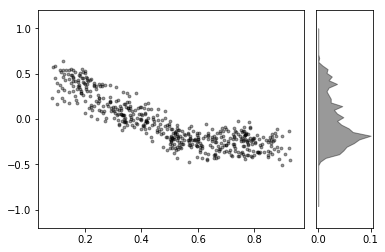

In [39]:
f,ax = plot_LAR(LAR_fd,EM_fd,cmap='bone')
f.savefig(os.path.join(basedir,'fd_simratio.pdf'),format='pdf')



In [40]:
mega_lar_fd = mega_lar(LAR_fd)

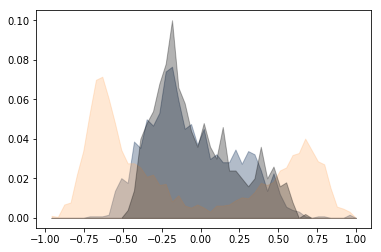

In [41]:
f,ax = plt.subplots()
bins = np.linspace(-1,1)
fam_hist,edges = np.histogram(mega_lar_fam,bins)
rare_hist,edges = np.histogram(mega_lar_rare,bins)
fd_hist,edges = np.histogram(mega_lar_fd,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))
ax.fill_between(edges[1:],fd_hist/fd_hist.sum(),alpha=.3,color=plt.cm.bone(0.))
f.savefig(os.path.join(basedir,'lsr_hist_fd.pdf'),format='pdf')